# Urban Vulnerability Assessment

In [1]:
import geopandas as gp
import networkx as nx
import pandas as pd
import numpy as np
import unidecode
import string
import datetime
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats
import warnings
from scipy.stats import gaussian_kde
warnings.filterwarnings('ignore')

from scipy.stats import chisquare, anderson, kstest

import matplotlib.pylab as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from scipy.spatial import distance

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Read the map

In [4]:
sectorUrbano = gp.read_file('./Data/MGN2018_URB_SECTOR')
sectorUrbano = sectorUrbano[(sectorUrbano['DPTO_CCDGO'] == '11') & (sectorUrbano['SETU_CCDGO'] != '0001')]
tost = sectorUrbano.copy()
tost = tost.to_crs({'init': 'epsg:3857'})
tost['area'] = tost['geometry'].area/ 10**6
dictAreas = tost.set_index('SETU_CCDGO')['area'].to_dict()
sectorUrbano['area'] = sectorUrbano['SETU_CCDGO'].apply(lambda x: dictAreas[x])
sectorUrbano['centroid'] = sectorUrbano.centroid

sectorUrbano.head()

,DPTO_CCDGO,MPIO_CCDGO,CPOB_CCDGO,SETU_CCNCT,SHAPE_Leng,SHAPE_Area,SETU_CCDGO,geometry,area,centroid
1538,11,11001,11001000,110011000000001101,0.017602,0.000014,1101,"POLYGON ((-74.08034 4.58187, -74.08064 4.58165...",0.172533,POINT (-74.08160 4.58323)
1539,11,11001,11001000,110011000000001102,0.024178,0.000021,1102,"POLYGON ((-74.07819 4.58107, -74.07789 4.58081...",0.266636,POINT (-74.08002 4.57926)
1540,11,11001,11001000,110011000000001103,0.051139,0.000072,1103,"POLYGON ((-74.07046 4.57786, -74.07037 4.57765...",0.896132,POINT (-74.07353 4.57410)
1541,11,11001,11001000,110011000000001104,0.032833,0.000032,1104,"POLYGON ((-74.06825 4.56809, -74.06821 4.56800...",0.400737,POINT (-74.06817 4.56410)
1542,11,11001,11001000,110011000000001105,0.072244,0.000071,1105,"POLYGON ((-74.07426 4.56748, -74.07413 4.56735...",0.885145,POINT (-74.07707 4.56209)


## Read the vulnerability variables

In [8]:
variables = pd.read_excel("./Data/variables_vulnerability.xlsx")

variables = variables[['SETU_CCDGO'] + variables.keys()[-15:].tolist()]
factors = variables.keys()[-15:].tolist()
variablesdict = variables.set_index('SETU_CCDGO', drop=True).to_dict()

sectorUrbanoWithVariables = sectorUrbano.copy()

for fc in factors:
    sectorUrbanoWithVariables[fc] = sectorUrbano['SETU_CCDGO'].apply(lambda x: variablesdict[fc][int(x)])

sectorUrbanoWithVariables = sectorUrbanoWithVariables.rename(columns={"Geographic Spread": "Geographic Impact"})
sectorUrbanoWithVariables

,DPTO_CCDGO,MPIO_CCDGO,CPOB_CCDGO,SETU_CCNCT,SHAPE_Leng,SHAPE_Area,SETU_CCDGO,geometry,area,centroid,...,Educational,Cultural,Sports,Food market,Formal labor,Informal labor,Public Transportation Dependency,Transmission Routes,Geographic Impact,Transmisibility
1538,11,11001,11001000,110011000000001101,0.017602,0.000014,1101,"POLYGON ((-74.08034 4.58187, -74.08064 4.58165...",0.172533,POINT (-74.08160 4.58323),...,37,5,3,0,2369,0.69,97696.41712,30939,24653,54096
1539,11,11001,11001000,110011000000001102,0.024178,0.000021,1102,"POLYGON ((-74.07819 4.58107, -74.07789 4.58081...",0.266636,POINT (-74.08002 4.57926),...,37,5,3,0,2369,0.69,97696.41712,30939,24653,54096
1540,11,11001,11001000,110011000000001103,0.051139,0.000072,1103,"POLYGON ((-74.07046 4.57786, -74.07037 4.57765...",0.896132,POINT (-74.07353 4.57410),...,12,17,0,1,910,0.24,95716.00310,36005,18931,54182
1541,11,11001,11001000,110011000000001104,0.032833,0.000032,1104,"POLYGON ((-74.06825 4.56809, -74.06821 4.56800...",0.400737,POINT (-74.06817 4.56410),...,34,17,0,1,1728,0.54,119887.70640,55448,39366,111982
1542,11,11001,11001000,110011000000001105,0.072244,0.000071,1105,"POLYGON ((-74.07426 4.56748, -74.07413 4.56735...",0.885145,POINT (-74.07707 4.56209),...,34,17,0,1,1728,0.54,119887.70640,55448,39366,111982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,11,11001,11001000,110011000000009218,0.048764,0.000086,9218,"POLYGON ((-74.12461 4.75408, -74.12354 4.75406...",1.071749,POINT (-74.11539 4.75006),...,51,14,1,1,6778,1.20,196491.47250,181040,92171,298532
2165,11,11001,11001000,110011000000009219,0.058952,0.000052,9219,"POLYGON ((-74.11956 4.74809, -74.11954 4.74809...",0.641471,POINT (-74.12417 4.74352),...,51,14,1,1,6778,1.20,196491.47250,181040,92171,298532
2166,11,11001,11001000,110011000000009220,0.036532,0.000043,9220,"POLYGON ((-74.09222 4.73695, -74.09221 4.73695...",0.528884,POINT (-74.09257 4.73487),...,135,35,0,1,12226,2.38,362496.90030,234887,143260,388004
2167,11,11001,11001000,110011000000009221,0.033188,0.000028,9221,"POLYGON ((-74.12395 4.74975, -74.12378 4.74919...",0.349619,POINT (-74.12691 4.74612),...,51,14,1,1,6778,1.20,196491.47250,181040,92171,298532


## Find the distribution

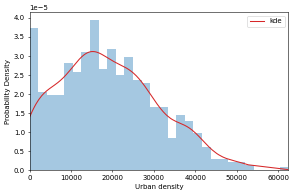

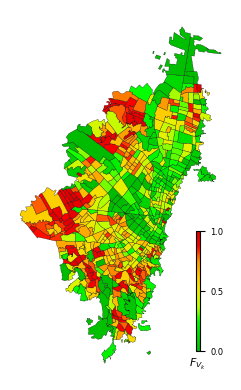

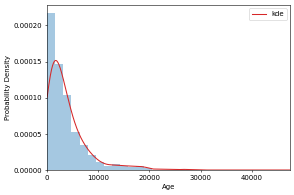

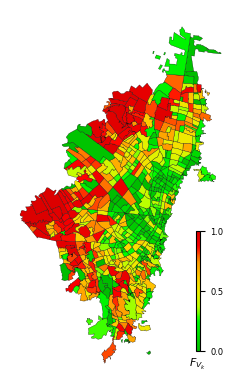

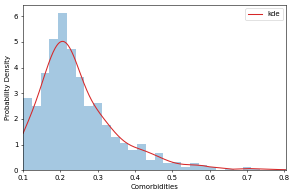

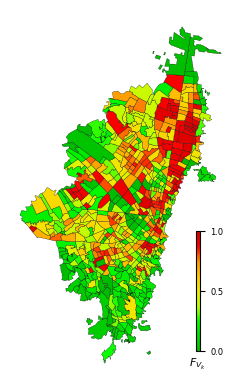

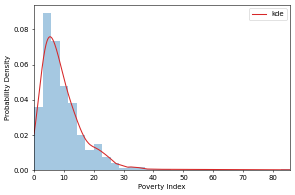

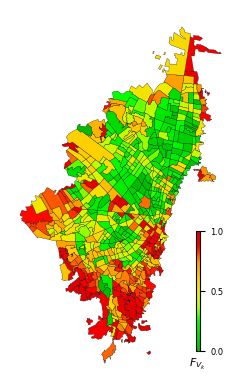

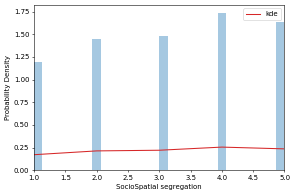

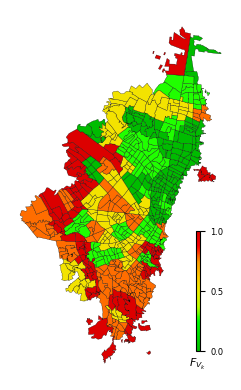

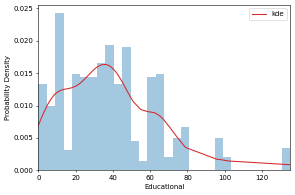

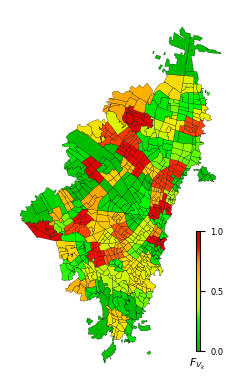

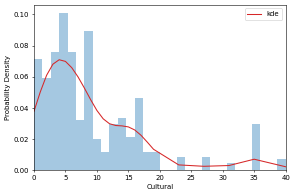

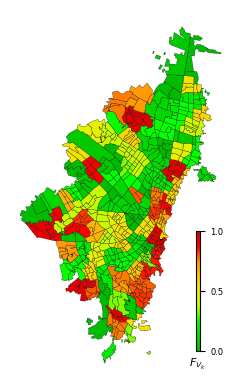

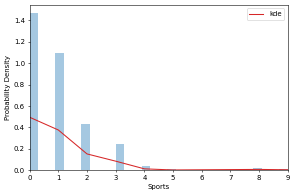

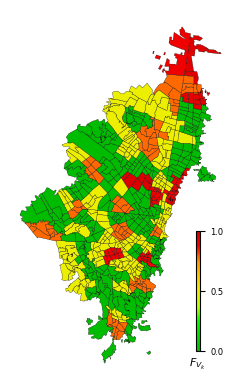

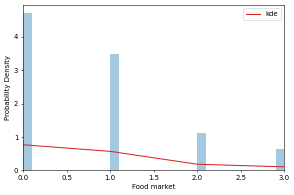

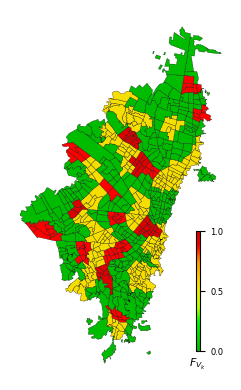

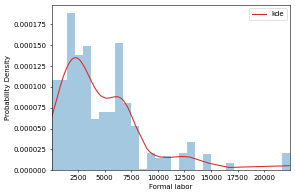

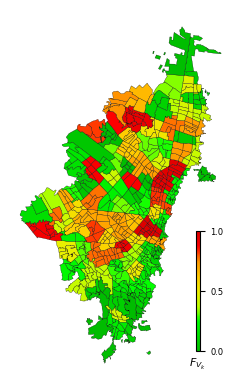

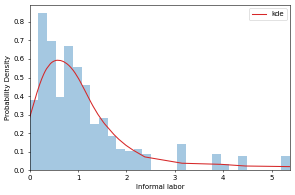

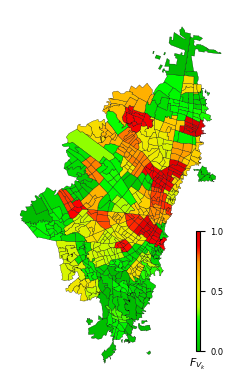

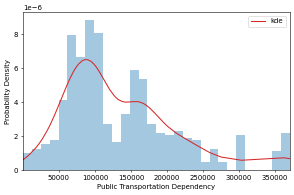

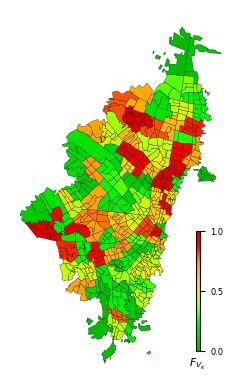

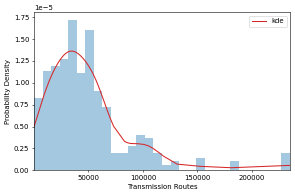

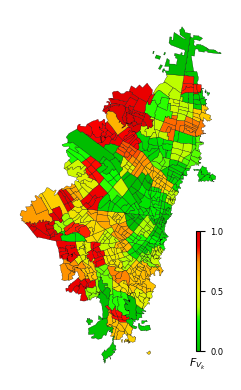

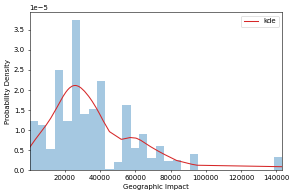

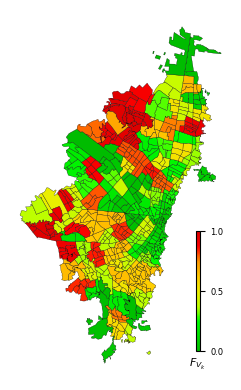

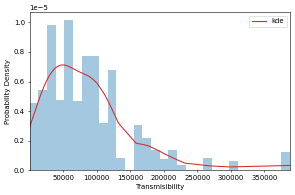

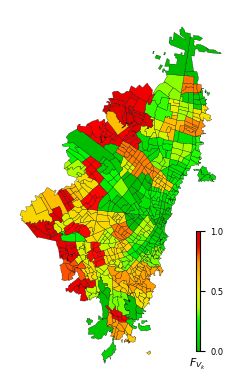

In [10]:
def plotVulnerabilityMap_withDistribution(var, colormap='', truncated = (0.5, 0.9)):
    myDPI = 100
    
    fig, ax = plt.subplots(dpi=myDPI)#figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)

    cmap = plt.get_cmap('nipy_spectral' + colormap)
    new_cmap = truncate_colormap(cmap, truncated[0], truncated[1])

    sectorUrbanoWithVariablesVulnerability.plot(ax = ax, column = var, edgecolor='black', cmap = new_cmap, lw=0.2)

    ax.axis('off')

    cax = plt.axes([0.625, 0.11, 0.008, 0.3])
    cax.tick_params(axis='both', which='major', labelsize=6)
    cax.tick_params(axis='both', which='minor', labelsize=6)
    cax.set_xlabel(r'$F_{V_k}$', fontsize=8)

    cmap = plt.get_cmap('nipy_spectral')
    new_cmap = truncate_colormap(cmap, truncated[0], truncated[1])
    some = ScalarMappable(cmap=new_cmap)
        

    some.set_clim(0, 1)
    cbar = fig.colorbar(some, 
                        cax=cax)

    cbar.set_ticks([0.0,  
                    0.5,  
                    1.0])
    
    fig.tight_layout()
    # fig.savefig(var + '_vulnerability.pdf', format='pdf')
    
    
# sns.set(style="white")
sectorUrbanoWithVariablesVulnerability = sectorUrbanoWithVariables.copy()


variables = sectorUrbanoWithVariables.columns[-15:].tolist()

#for var in variables[:1]:
for var in variables:
    fig1, ax1 = plt.subplots(dpi=50)
    sns.distplot(sectorUrbanoWithVariables[var], ax = ax1, bins=30, kde_kws={"color": "none"},);

    kernel = gaussian_kde(sectorUrbanoWithVariables[var])

    pdf_fitted = kernel.evaluate(sectorUrbanoWithVariables[var])
    X = np.array([sectorUrbanoWithVariables[var], pdf_fitted]).T
    X = X[X[:,0].argsort()]
    ax1.plot(X[:, 0], X[:, 1], label='kde', c='C3')

    ax1.set_xlim(sectorUrbanoWithVariables[var].min(), sectorUrbanoWithVariables[var].max())
    ax1.set_ylabel('Probability Density')
    ax1.legend()

    fig1.tight_layout()        
    # fig1.savefig(var + '_dist.pdf', format='pdf')
    
    if var == 'SocioSpatial segregation':
        sectorUrbanoWithVariablesVulnerability[var + '- VALUE'] = 1 - sectorUrbanoWithVariablesVulnerability[var].apply(lambda x: kernel.integrate_box_1d(0, x))
    else:
        sectorUrbanoWithVariablesVulnerability[var + '- VALUE'] = sectorUrbanoWithVariablesVulnerability[var].apply(lambda x: kernel.integrate_box_1d(0, x))

    plotVulnerabilityMap_withDistribution(var + '- VALUE')

## Cluster analysis

In [12]:
from sklearn.cluster import *
from sklearn.mixture import GaussianMixture

sectorUrbanoWithVariablesVulnerabilityClusters = sectorUrbanoWithVariablesVulnerability.copy()
clusterDataWithLabels = sectorUrbanoWithVariablesVulnerability.copy()[['SETU_CCNCT'] + sectorUrbanoWithVariablesVulnerability.columns[-14:].tolist()]
clusterData = clusterDataWithLabels.copy()

kmeanModel_3 = KMeans(n_clusters=3)
kmeanModel_3.fit(clusterData[clusterData.columns[1:]])
clusterDataWithLabels['Cluster 3'] = kmeanModel_3.labels_

kmeanModel_5 = KMeans(n_clusters=5)
kmeanModel_5.fit(clusterData[clusterData.columns[1:]])
clusterDataWithLabels['Cluster 5'] = kmeanModel_5.labels_

kmeanModel_10 = KMeans(n_clusters=10)
kmeanModel_10.fit(clusterData[clusterData.columns[1:]])
clusterDataWithLabels['Cluster 10'] = kmeanModel_10.labels_

clusters = clusterDataWithLabels[['SETU_CCNCT', 'Cluster 3', 'Cluster 5', 'Cluster 10']].set_index('SETU_CCNCT').to_dict(orient='index')

sectorUrbanoWithVariablesVulnerabilityClusters['Cluster 3'] = sectorUrbanoWithVariablesVulnerabilityClusters['SETU_CCNCT'].apply(lambda x: clusters[x]['Cluster 3'])
sectorUrbanoWithVariablesVulnerabilityClusters['Cluster 5'] = sectorUrbanoWithVariablesVulnerabilityClusters['SETU_CCNCT'].apply(lambda x: clusters[x]['Cluster 5'])
sectorUrbanoWithVariablesVulnerabilityClusters['Cluster 10'] = sectorUrbanoWithVariablesVulnerabilityClusters['SETU_CCNCT'].apply(lambda x: clusters[x]['Cluster 10'])

sectorUrbanoWithVariablesVulnerabilityClusters.head()

,DPTO_CCDGO,MPIO_CCDGO,CPOB_CCDGO,SETU_CCNCT,SHAPE_Leng,SHAPE_Area,SETU_CCDGO,geometry,area,centroid,...,Food market- VALUE,Formal labor- VALUE,Informal labor- VALUE,Public Transportation Dependency- VALUE,Transmission Routes- VALUE,Geographic Impact- VALUE,Transmisibility- VALUE,Cluster 3,Cluster 5,Cluster 10
1538,11,11001,11001000,110011000000001101,0.017602,0.000014,1101,"POLYGON ((-74.08034 4.58187, -74.08064 4.58165...",0.172533,POINT (-74.08160 4.58323),...,0.000000,0.258957,0.348808,0.367331,0.313268,0.333081,0.311010,0,2,2
1539,11,11001,11001000,110011000000001102,0.024178,0.000021,1102,"POLYGON ((-74.07819 4.58107, -74.07789 4.58081...",0.266636,POINT (-74.08002 4.57926),...,0.000000,0.258957,0.348808,0.367331,0.313268,0.333081,0.311010,0,2,2
1540,11,11001,11001000,110011000000001103,0.051139,0.000072,1103,"POLYGON ((-74.07046 4.57786, -74.07037 4.57765...",0.896132,POINT (-74.07353 4.57410),...,0.411236,0.076243,0.093536,0.354782,0.382131,0.218880,0.311620,2,0,5
1541,11,11001,11001000,110011000000001104,0.032833,0.000032,1104,"POLYGON ((-74.06825 4.56809, -74.06821 4.56800...",0.400737,POINT (-74.06817 4.56410),...,0.411236,0.173307,0.260045,0.491464,0.625889,0.609894,0.679745,2,4,6
1542,11,11001,11001000,110011000000001105,0.072244,0.000071,1105,"POLYGON ((-74.07426 4.56748, -74.07413 4.56735...",0.885145,POINT (-74.07707 4.56209),...,0.411236,0.173307,0.260045,0.491464,0.625889,0.609894,0.679745,2,4,6


## Agregation method (Borda)

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='Cluster 10')
14
15
[2.0, 8.0, 7.0, 9.0, 4.0, 6.0, 10.0, 1.0, 3.0, 5.0]


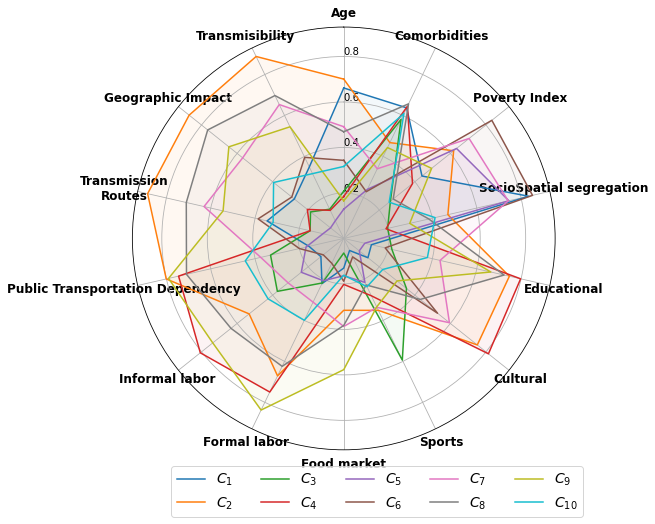

In [13]:
Cluster = 10

def borda_sort(lists):
    scores = {};
    for l in lists:
        for idx, elem in enumerate(l):
            if not elem in scores:
                scores[elem] = 0
            scores[elem] += idx
            
    return sorted(scores.keys(), key=lambda x: scores[x],reverse = False)

cl = Cluster
tmpData = clusterDataWithLabels.groupby('Cluster ' + str(cl)).mean()[clusterData.keys()[1:]].T
fullRanking = []
for i in tmpData.values:
    ranking = [0]*len(i)
    fullRanking.append(i.argsort()[::-1])

tmpData[['Ranking ' + str(key) for key in tmpData.keys()]] = fullRanking

some = borda_sort(tmpData[tmpData.keys()[-cl:]].values)
# print(some)
#pd.DataFrame(fullRanking, index = tmpData.index, columns = tmpData.columns)
# tmpData# [['Ranking 0', 'Ranking 1', 'Ranking 2']]



tmpData = clusterDataWithLabels.groupby('Cluster ' + str(Cluster)).mean()[clusterData.keys()[1:]].T
print(tmpData.keys())

# plt.rcParams["figure.figsize"] = (9,9)
# ------- PART 1: Create background
 
# number of variable
categories = [i.split('-')[0] for i in tmpData.index]
categories[-3] = "\n".join( [" ".join(categories[-3].split()[:-1])] + [categories[-3].split()[-1]])
N = tmpData.shape[0]

print(N)
from math import pi
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
    
    
# Initialise the spider plot
f = plt.figure(figsize=(9,9))

ax = f.add_subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2.0)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet

 
# Draw ylabels
ax.set_rlabel_position(0)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
#values = completeData.loc[0].drop('group').values.flatten().tolist()
#values += values[:1]
listOfColors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for i, c in zip(tmpData.keys(), listOfColors):
    values = tmpData[i].values 
    values = np.append(values, values[0])
    ax.plot(angles, values, linewidth=1.5, color=c, linestyle='solid', label= r"$C_{" + str(i+1) +"}$")
    ax.fill(angles, values, c, alpha=0.05)
    
ax.set_aspect('equal')
# Add legend

#plt.xticks([i for i in range(len(indexSome))], indexSome)
print(len(angles))
plt.xticks(angles[:-1], categories, fontweight='bold', fontsize=12)

if Cluster == 10:
    ax.legend(loc='lower left', bbox_to_anchor=(0.075, -0.175), ncol=5, fontsize=14)
elif Cluster == 3:
    ax.legend(loc='lower left', bbox_to_anchor=(0.25, -0.125), ncol=Cluster, fontsize=14)
else:
    ax.legend(loc='lower left', bbox_to_anchor=(0.075, -0.125), ncol=Cluster, fontsize=14)
    
print([l+1 for l in some])
f.tight_layout()

# ax.axis("off")
# plt.savefig('./Dataset_AnomalyDetection/' + selectedDataset.split('/')[2].split('.')[0] + '.pdf', format='pdf')
# plt.savefig(str(Cluster) + '_clusters_values.pdf', format='pdf')

## Vulnerability Index

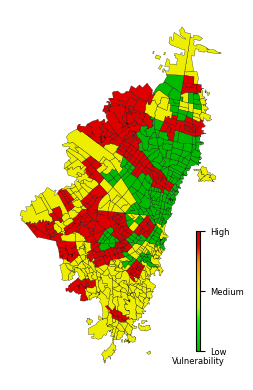

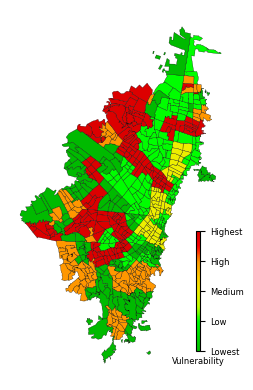

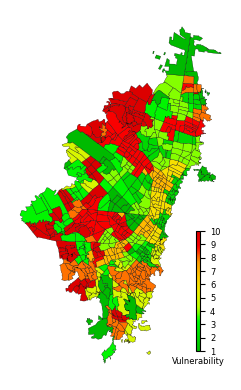

In [15]:
from matplotlib.patches import Patch
import matplotlib.colors 
# matplotlib.style.use('ggplot')

def plotVulnerabilityMap_full(var, cl, truncated = (0.5, 0.9)):
    myDPI = 100
    
    fig, ax = plt.subplots(dpi=myDPI)#figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)

    cmap = plt.get_cmap('nipy_spectral')
    new_cmap = truncate_colormap(cmap, truncated[0], truncated[1])

    listOfColors = [resultsBorda[numberOfCluster]['colors'][i] for i in range(numberOfCluster)]
    cmapVulnerability = matplotlib.colors.ListedColormap(listOfColors) 
    sectorUrbanoWithVariablesVulnerabilityClusters.plot(ax = ax, column = 'Cluster ' + str(numberOfCluster), edgecolor='black', cmap = cmapVulnerability, lw=0.2)

    ax.axis('off')
    
    cax = plt.axes([0.625, 0.11, 0.008, 0.3])
    cax.tick_params(axis='both', which='major', labelsize=6)
    cax.tick_params(axis='both', which='minor', labelsize=6)
    cax.set_xlabel('Vulnerability', fontsize=6)

    cmap = plt.get_cmap('nipy_spectral')
    new_cmap = truncate_colormap(cmap, truncated[0], truncated[1])
    some = ScalarMappable(cmap=new_cmap)
        

    some.set_clim(0, 1)
    cbar = fig.colorbar(some, 
                        cax=cax)
    
    # colors_clusters = [new_cmap(float(i)/float(cl-1)) for i in range(cl)]    
    cbar.set_ticks([float(i)/float(cl-1) for i in range(cl)])
    
    if cl == 3:
        cbar.set_ticklabels(['Low', 'Medium', 'High'])
    elif cl == 5:
        cbar.set_ticklabels(['Lowest', 'Low', 'Medium', 'High', 'Highest'])
    else:
        cbar.set_ticklabels([str(_) for _ in range(1, 11)])
        
    fig.tight_layout()
    # fig.savefig(var + '_vulnerability.pdf', format='pdf')

def assign_colors(borda_count, cl):
    truncated = (0.1, 0.5)
    cmap = plt.get_cmap('nipy_spectral_r')
    new_cmap = truncate_colormap(cmap, truncated[0], truncated[1])

    colors_clusters = [new_cmap(float(i)/float(cl-1)) for i in range(cl)]    
    
    colors_map = {}
    for index, value in enumerate(borda_count):
        # print(value, colors_clusters[index])
        colors_map[value] = colors_clusters[index]
    return colors_map

    
resultsBorda = {}

for cl in [3, 5, 10]:
#for cl in [3]:
    tmpData = clusterDataWithLabels.groupby('Cluster ' + str(cl)).mean()[clusterData.keys()[1:]].T
    fullRanking = []
    for i in tmpData.values:
        ranking = [0]*len(i)
        fullRanking.append(i.argsort()[::-1])

    tmpData[['Raking ' + str(key) for key in tmpData.keys()]] = fullRanking
    #pd.DataFrame(fullRanking, index = tmpData.index, columns = tmpData.columns)
    borda_count_vulnerability = borda_sort(tmpData[tmpData.keys()[-cl:]].values)
    resultsBorda[cl] = {'borda_count': borda_count_vulnerability, 
                        'colors': assign_colors(borda_count_vulnerability, cl)}
    
for numberOfCluster in [3, 5, 10]:
    plotVulnerabilityMap_full('Cluster ' + str(numberOfCluster), numberOfCluster)